<a href="https://colab.research.google.com/github/Kcurr01/HUT_Research/blob/main/VAE_11_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
Instalation 
---

In [1]:
!pip install captum
!pip install umap-learn
!pip install datashader
!pip install bokeh
!pip install holoviews

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 36.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=624f756fe88693b53676d954e48e707b6c70ea9fee779a9e65d372cb910b4470
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=eb0bbe634364be7efcb3f19d34962f133d13049ffec6c126130f3dd9d3b63dd9
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-p

---
VAE Initializaiton, Visualization and Training
--- 

In [16]:
import torch   
import torch.nn as nn                          
import torch.nn.functional as F                
import torch.optim as optim   
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.autograd import Variable
import torch.utils.data

import pandas as pd 
import numpy as np
import os                             

from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

import matplotlib.pyplot as plt
import seaborn as sns    
import plotly.offline as py
import plotly.graph_objs as go        
                
from tqdm import tqdm

import umap
import umap.plot

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#based on sensor data can you determine the stimulus that is currently in use?

In [17]:
df = pd.read_csv("/content/drive/MyDrive/WEAR_LAB/Research_Pytorch/S1_E1_A1_v3.csv")

In [18]:
#df = df.drop(columns=['series_id'])
df.head()

,stimulus,Acc 1,Acc 2,Acc 3,EMG Channel 1,EMG Channel 2,EMG Channe 3,EMG Channel 4,EMG Channel 5,EMG Channel 6,...,Cyber Glove (angles of the joints) Sensor 13,Cyber Glove (angles of the joints) Sensor 14,Cyber Glove (angles of the joints) Sensor 15,Cyber Glove (angles of the joints) Sensor 16,Cyber Glove (angles of the joints) Sensor 17,Cyber Glove (angles of the joints) Sensor 18,Cyber Glove (angles of the joints) Sensor 19,Cyber Glove (angles of the joints) Sensor 20,Cyber Glove (angles of the joints) Sensor 21,Cyber Glove (angles of the joints) Sensor 22
0,0,0.30176,0.78809,-0.66699,-22,-2,-16,-7,-3,-1,...,20.974,-25.345,-3.9720,27.264,21.548,-0.084706,13.292,65.755,2.4706,24.565
1,0,0.30176,0.78809,-0.66699,5,-4,-12,-3,8,25,...,20.924,-25.345,-3.9011,27.264,21.478,-0.084706,13.292,65.755,2.4706,24.565
2,0,0.30176,0.78809,-0.66699,-6,1,4,-1,-9,0,...,20.875,-25.345,-3.8301,27.264,21.407,-0.084706,13.292,65.755,2.4706,24.565
3,0,0.30176,0.78809,-0.66699,15,10,19,9,10,7,...,20.826,-25.345,-3.7592,27.264,21.337,-0.084706,13.292,65.755,2.4706,24.565
4,0,0.24609,0.73535,-0.66309,-1,-16,-17,0,-2,-7,...,20.776,-25.345,-3.6883,27.264,21.267,-0.084706,13.292,65.755,2.4706,24.565


In [19]:
#df.describe()
#df.plot()

In [20]:
X = df.iloc[:,1:]
y = df.iloc[:, 0:1]
print(X.shape, type(X), y.shape, type(y))
print()
#print(y.value_counts())

(130200, 41) <class 'pandas.core.frame.DataFrame'> (130200, 1) <class 'pandas.core.frame.DataFrame'>



In [21]:
X.head()

,Acc 1,Acc 2,Acc 3,EMG Channel 1,EMG Channel 2,EMG Channe 3,EMG Channel 4,EMG Channel 5,EMG Channel 6,EMG Channel 7,...,Cyber Glove (angles of the joints) Sensor 13,Cyber Glove (angles of the joints) Sensor 14,Cyber Glove (angles of the joints) Sensor 15,Cyber Glove (angles of the joints) Sensor 16,Cyber Glove (angles of the joints) Sensor 17,Cyber Glove (angles of the joints) Sensor 18,Cyber Glove (angles of the joints) Sensor 19,Cyber Glove (angles of the joints) Sensor 20,Cyber Glove (angles of the joints) Sensor 21,Cyber Glove (angles of the joints) Sensor 22
0,0.30176,0.78809,-0.66699,-22,-2,-16,-7,-3,-1,-2,...,20.974,-25.345,-3.9720,27.264,21.548,-0.084706,13.292,65.755,2.4706,24.565
1,0.30176,0.78809,-0.66699,5,-4,-12,-3,8,25,1,...,20.924,-25.345,-3.9011,27.264,21.478,-0.084706,13.292,65.755,2.4706,24.565
2,0.30176,0.78809,-0.66699,-6,1,4,-1,-9,0,-10,...,20.875,-25.345,-3.8301,27.264,21.407,-0.084706,13.292,65.755,2.4706,24.565
3,0.30176,0.78809,-0.66699,15,10,19,9,10,7,2,...,20.826,-25.345,-3.7592,27.264,21.337,-0.084706,13.292,65.755,2.4706,24.565
4,0.24609,0.73535,-0.66309,-1,-16,-17,0,-2,-7,2,...,20.776,-25.345,-3.6883,27.264,21.267,-0.084706,13.292,65.755,2.4706,24.565


In [22]:
y.head()

,stimulus
0,0
1,0
2,0
3,0
4,0


---
Visulaize number of lables

0     49599
8      6795
5      6782
6      6776
7      6776
11     6773
1      6753
12     6701
10     6696
2      6656
4      6654
9      6626
3      6613
Name: stimulus, dtype: int64

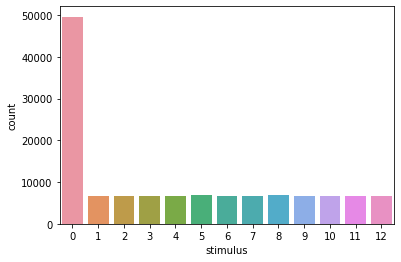

In [23]:
sns.countplot(x = 'stimulus', data=df)
df.loc[:,'stimulus'].value_counts()

In [24]:
# Grouping
stimulus = df.groupby("stimulus")
stimulus.mean()

,Acc 1,Acc 2,Acc 3,EMG Channel 1,EMG Channel 2,EMG Channe 3,EMG Channel 4,EMG Channel 5,EMG Channel 6,EMG Channel 7,...,Cyber Glove (angles of the joints) Sensor 13,Cyber Glove (angles of the joints) Sensor 14,Cyber Glove (angles of the joints) Sensor 15,Cyber Glove (angles of the joints) Sensor 16,Cyber Glove (angles of the joints) Sensor 17,Cyber Glove (angles of the joints) Sensor 18,Cyber Glove (angles of the joints) Sensor 19,Cyber Glove (angles of the joints) Sensor 20,Cyber Glove (angles of the joints) Sensor 21,Cyber Glove (angles of the joints) Sensor 22
stimulus,,,,,,,,,,,,,,,,,,,,,
0,-0.056010,0.717684,-0.688866,-0.861005,-0.925886,-0.900643,-0.817476,-0.812698,-0.810702,-0.810460,...,22.374131,-24.390196,6.475231,33.826151,15.840117,1.916654,16.316644,57.351923,12.082464,9.313205
1,-0.035925,0.728237,-0.679172,-0.867762,-1.146157,-0.909226,-0.823486,-0.825559,-0.828521,-0.820524,...,15.707708,-24.017138,4.713040,30.373064,12.204117,-1.052761,16.309700,65.589193,13.237948,9.183145
2,-0.042732,0.717892,-0.690736,-0.863732,-0.956731,-0.908203,-0.816556,-0.816256,-0.806340,-0.826472,...,16.935157,-26.196097,5.104126,27.608420,13.697377,0.925270,15.825755,58.212362,16.571733,8.595896
3,-0.036814,0.740875,-0.666074,-0.882353,-1.013307,-0.902616,-0.822773,-0.828520,-0.796764,-0.819598,...,13.701679,-25.081852,5.223214,41.024695,14.406630,0.072327,16.363093,65.250188,10.711256,10.198552
4,-0.038913,0.740577,-0.666245,-0.853472,-3.189209,-0.941689,-0.822663,-0.820409,-0.821461,-0.814397,...,21.157855,-26.636876,-0.738678,33.480758,21.775733,0.978099,15.884901,63.641231,11.032709,10.373940
5,-0.043166,0.749575,-0.655838,-0.855058,-1.065910,-0.898850,-0.826600,-0.844736,-0.885579,-0.842967,...,57.631099,-29.244141,1.171615,40.958863,9.042010,0.149424,16.076867,62.645036,9.423282,11.213689
6,-0.055524,0.745480,-0.658593,-0.884002,-1.320396,-0.959711,-0.824823,-0.838400,-0.813312,-0.828512,...,-9.245567,-20.894008,6.271624,46.492966,-8.034011,-1.084727,13.912160,50.432202,5.327640,10.621614
7,-0.059483,0.746586,-0.657206,-0.871458,-1.100354,-0.895956,-0.832645,-0.827627,-0.828512,-0.821281,...,3.421609,-28.433760,7.771147,52.820468,10.054756,-4.241344,14.274136,46.689242,4.316392,9.942229
8,-0.050231,0.745785,-0.659394,-0.988668,-2.184106,-0.917292,-0.822811,-0.842678,-0.818543,-0.822958,...,7.817003,-27.863156,8.470147,13.671039,-0.325672,1.947009,9.316914,50.982750,5.681819,11.839359


---
Visualize Data Disturbutions


In [25]:
# #distribution of first 16 features


# fig, axs = plt.subplots(nrows=11, ncols=4, figsize=(60, 60))
# axs = axs.flatten()
# index = 0
# for k, v in df.items():
#   print(f"[{index +1}] Updating plot")
#   sns.distplot(v, ax=axs[index])
#   index += 1
#   if index == 43:
#     break 
# plt.tight_layout()


In [26]:
X = df.iloc[:,1:].values
y = df.iloc[:, 0:1].values
print(X.shape, type(X), y.shape, type(y))

# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(f"X_train size: {len(X_train)} | X_val size: {len(X_val)} | X_test size: {len(X_test)}")
print(f"y_train size: {len(y_train)} | y_val size: {len(y_val)} | y_test size: {len(y_test)}")
print()
print(f"Training Feature Split: {X_train.shape} | Training Labels { y_train.shape}")
print(f"Validation Feature Split: {X_val.shape} | Validation Labels { y_val.shape}")
print(f"Testing Feature Split: {X_test.shape} | Testing Labels { y_test.shape}")
print()

#Normalization Data 
Minmax = preprocessing.MinMaxScaler()
#Standardized = preprocessing.StandardScaler()
X_train_Minmax= Minmax.fit_transform(X_train)
X_val_Minmax = Minmax.transform(X_val)
X_test_Minmax = Minmax.transform(X_test)

#Convert to numpy then to torch 

X_train = torch.from_numpy(X_train_Minmax).float()
y_train = torch.from_numpy(y_train).float()

X_val = torch.from_numpy(X_val_Minmax).float()
y_val = torch.from_numpy(y_val).float()

X_test = torch.from_numpy(X_test_Minmax).float()
y_test = torch.from_numpy(y_test).float()

print(f"X_train: {type(X_train)} | y_train {type(y_train)}")
print(f"X_val: {type(X_val)} | y_train {type(y_val)}")
print(f"X_test: {type(X_test)} | y_test {type(y_test)}")
print()
print(f"Training: {X_train.shape} , { y_train.shape}")
print(f"Validation: {X_val.shape} , { y_val.shape}")
print(f"Testing:  {X_test.shape} , { y_test.shape}")

(130200, 41) <class 'numpy.ndarray'> (130200, 1) <class 'numpy.ndarray'>
X_train size: 78120 | X_val size: 26040 | X_test size: 26040
y_train size: 78120 | y_val size: 26040 | y_test size: 26040

Training Feature Split: (78120, 41) | Training Labels (78120, 1)
Validation Feature Split: (26040, 41) | Validation Labels (26040, 1)
Testing Feature Split: (26040, 41) | Testing Labels (26040, 1)

X_train: <class 'torch.Tensor'> | y_train <class 'torch.Tensor'>
X_val: <class 'torch.Tensor'> | y_train <class 'torch.Tensor'>
X_test: <class 'torch.Tensor'> | y_test <class 'torch.Tensor'>

Training: torch.Size([78120, 41]) , torch.Size([78120, 1])
Validation: torch.Size([26040, 41]) , torch.Size([26040, 1])
Testing:  torch.Size([26040, 41]) , torch.Size([26040, 1])


In [42]:
class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)

training = ClassifierDataset(X_train, y_train)
validating = ClassifierDataset(X_val, y_val)
testing = ClassifierDataset(X_test, y_test)

x_sample, y_sample = training[0]
print(f'elements of x_sample : \n{x_sample[:10]} \nand y_sample : \n{y_sample}')
print(f'x_sample shape : {x_sample.shape} and y_sample shape : {y_sample.shape}')

###############################################################################################
#Hyperparameters
latent_dim = 2
input_dim= 41
hidden_dim= 20
output_dim = 41
num_epochs= 10
batch_size= 100
num_classes = 13
learning_rate= 0.0001 #3e-4 #Karpathy constant

#beta = 1
beta = 0.05
alpha = 1

train_loader = DataLoader(training, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validating, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testing, batch_size=batch_size, shuffle=False)


elements of x_sample : 
tensor([0.4282, 0.7040, 0.5881, 0.4902, 0.4902, 0.4486, 0.4894, 0.5179, 0.4896,
        0.4661]) 
and y_sample : 
tensor([12.])
x_sample shape : torch.Size([41]) and y_sample shape : torch.Size([1])


In [28]:
# classification and matrix 

# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors = 3)
# knn.fit(X_train,y_train.ravel())
# prediction = knn.predict(X_train)
# print('With KNN (K=3) accuracy is: ',knn.score(X_test,y_test)) # accuracy
# print('Prediction: {}'.format(prediction))
# print("-------------\n")

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix
# rf = RandomForestClassifier(random_state = 4)
# rf.fit(X_train,y_train.ravel())
# y_pred = rf.predict(X_test)
# cm = confusion_matrix(y_test,y_pred)
# print('Confusion matrix: \n',cm)
# print('Classification report: \n',classification_report(y_test,y_pred))
# y_prediciton = rf.predict(X_test)
# score = accuracy_score(y_test, y_prediciton)
# sns.heatmap(cm,annot=True,fmt="d") 
# plt.show()

In [43]:
class VAE(nn.Module):  
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VAE,self).__init__()  
    self.fc1 = nn.Linear(input_dim, hidden_dim)  # no labels
    self.mu = nn.Linear(hidden_dim, latent_dim)   # mu
    self.logvar = nn.Linear(hidden_dim,latent_dim)   # log-var

    self.fc3 = nn.Linear(latent_dim, hidden_dim) 
    self.fc4 = nn.Linear(hidden_dim, input_dim)
    
    self.classifier = nn.Sequential(
        nn.Linear(latent_dim, 2),
        nn.ReLU(),
        nn.Sigmoid(),
        nn.Softmax(dim=1)
    )

  def encode(self, x):     
#    print(f'encoder {type(x)}')         
    z = F.relu(self.fc1(x))
    z = torch.tanh(z) 
    z1 = self.mu(z)               
    z2 = self.logvar(z) 
    return z1, z2                 # (mu, log-var)

  def decode(self, x):
#    print(f'decoder {type(x)}')
    z = F.relu(self.fc3(x))                    
    z = torch.sigmoid(self.fc4(z))      # in [0, 1]
    #print(f"z: {z}")
    return z 

  def forward(self, x):
#    print(f'forward {type(x)}')

#  Reparamaterize
    mu, logvar = self.encode(x)
    stdev = torch.exp(0.5 * logvar)
    esp = torch.randn_like(stdev)
    z_reparmeterized = mu + (esp * stdev)   
    #print(f"z_reparmeterized : {z_reparmeterized}")      
    x_reconstructed = self.decode(z_reparmeterized)
    #print(f"x_reconstructed : {x_reconstructed}")

    out = self.classifier(z_reparmeterized)

    return (x_reconstructed, out, mu, logvar)

if __name__ == "__main__":
  x = torch.rand(batch_size,input_dim)
  vae = VAE(input_dim, hidden_dim, latent_dim)
  x_reconstructed, out, mu, logvar = vae(x)
  print(x_reconstructed.shape)
  print(mu.shape)
  print(logvar.shape)
  print(out.shape)


torch.Size([100, 41])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])


In [44]:
model  = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)
loss_fn = nn.MSELoss(reduction="sum")
classifier_loss_fn = nn.CrossEntropyLoss()

def accuracy(y_pred, y_act):
  y_pred = torch.round(y_pred)
  correct = (y_pred == y_act)
  acc1 = correct.sum()/len(correct)
  acc2 = torch.round(acc1*100)
  # print(f"z_pred: {y_pred} | lable: {y_act} | correct: {correct} | accuracy {acc1} | accuracy {acc2}")
  return acc2

VAE(
  (fc1): Linear(in_features=41, out_features=20, bias=True)
  (mu): Linear(in_features=20, out_features=2, bias=True)
  (logvar): Linear(in_features=20, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=41, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Sigmoid()
    (3): Softmax(dim=1)
  )
)


In [45]:
train_losses=[]
val_losses=[]
accuracy_list = []

dic = dict(latent_space = list(), mu_list=list(), logsig2_list=list(), y=list())
for epoch in range(num_epochs):
  model.train()
  #print(f"zvalue loop begin {z}")
  train_running_loss = 0
  train_running_acc = 0
#  loop = tqdm(train_loader)
  for i, data in enumerate(train_loader):
    inputs, labels = data
    #print(f'type data: {type(data)}')
    #print(f'type inputs: {type(inputs)}')
    #print(f'type labels: {type(labels)}')

    x_reconstructed, out ,mu, logvar = model(inputs)
    #print(x_reconstructed, type(x_reconstructed))
    #print(mu, type(mu))
    #print(logvar, type(logvar))

    reconstruction_loss = loss_fn(x_reconstructed, inputs)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = alpha*reconstruction_loss + kld_loss*beta

    acc_train = accuracy(out, labels)
    #print(reconstruction_loss, kld_loss, loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
    train_loss= train_running_loss/len(train_loader)

    train_running_acc += acc_train.item()
    train_acc = train_running_acc/len(train_loader)

  
  z_list, means, logvars , labels = list(), list(), list(), list()

  #Evaluation
  with torch.inference_mode():
    val_running_loss = 0

    model.eval()
    for X, Y in val_loader:
      #print(labels)
      #inputs = torch.autograd.Variable(inputs)
      y_pred, z_reparmeterized, mu, logvar = model(X)
      v_reconstruction_loss = loss_fn(y_pred, X)
      v_kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
      vloss = alpha*v_reconstruction_loss + v_kld_loss*beta
      #print(v_reconstruction_loss, v_kld_loss, vloss)
      val_running_loss += vloss.item()
      val_loss = val_running_loss/len(val_loader)

      # log ...
      z_list.append(z_reparmeterized.detach())
      means.append(mu.detach())
      logvars.append(logvar.detach())
      labels.append(Y.detach())

  dic['latent_space'].append(torch.cat(z_list))
  dic['mu_list'].append(torch.cat(means))
  dic['logsig2_list'].append(torch.cat(logvars))
  dic['y'].append(torch.cat(labels))

  print(f"Epoch: {epoch+1} / {num_epochs} | reconst_loss: {reconstruction_loss:.3f} | kldiv loss: {kld_loss:.5f} | total loss: {train_loss:.3f} | train acc: {train_acc:.3f} ||| Val Loss: {val_loss:.3f}")
  print("------------------------------------------------------------------------------------------------------------------")
  #print(f"Epoch: {epoch+1} / {num_epochs} | reconst_loss: {v_reconstruction_loss:.3f} | kldiv loss: {v_kld_loss:.3f} | Val Loss: {val_loss:.3f}")
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  



Epoch: 1 / 10 | reconst_loss: 12.061 | kldiv loss: 34.38624 | total loss: 106.520 | train acc: 46.864 ||| Val Loss: 70.787
------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | reconst_loss: 8.001 | kldiv loss: 35.06941 | total loss: 60.133 | train acc: 43.537 ||| Val Loss: 55.236
------------------------------------------------------------------------------------------------------------------
Epoch: 3 / 10 | reconst_loss: 9.328 | kldiv loss: 27.30875 | total loss: 53.265 | train acc: 45.258 ||| Val Loss: 51.845
------------------------------------------------------------------------------------------------------------------
Epoch: 4 / 10 | reconst_loss: 7.506 | kldiv loss: 22.20912 | total loss: 50.870 | train acc: 47.724 ||| Val Loss: 50.109
------------------------------------------------------------------------------------------------------------------
Epoch: 5 / 10 | reconst_loss: 6.017 | kldiv loss: 17.5

In [32]:
torch.save(model.state_dict(), 'VAE_Model.pt') # Save

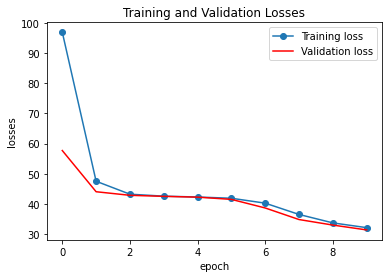

In [33]:
plt.plot(train_losses,'-o', label="Training loss")
plt.plot(val_losses,'-r',  label="Validation loss")
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

Latent Space Visualization
Latent Space Image 1 stored.
Latent Space Image 2 stored.
Latent Space Image 3 stored.
Latent Space Image 4 stored.
Latent Space Image 5 stored.
Latent Space Image 6 stored.
Latent Space Image 7 stored.
Latent Space Image 8 stored.
Latent Space Image 9 stored.
Latent Space Image 10 stored.


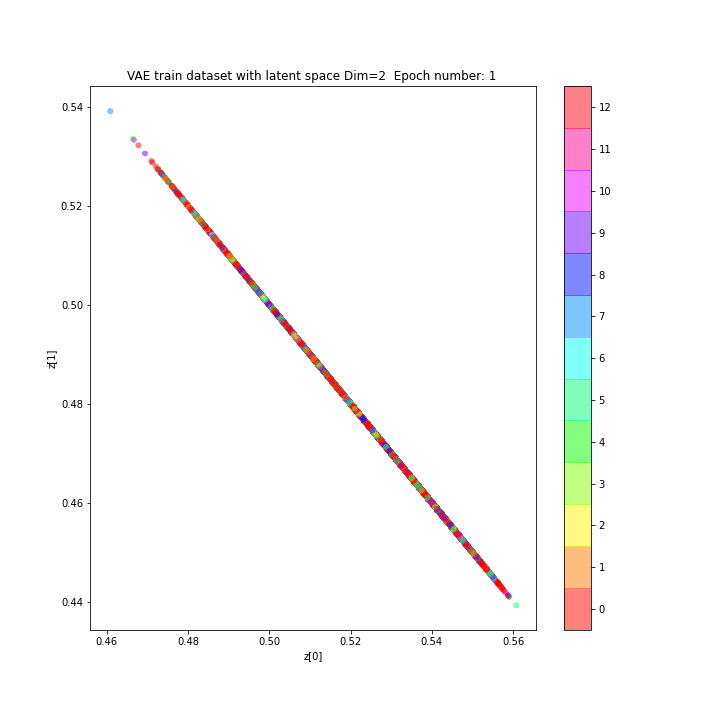

In [34]:
print("Latent Space Visualization")
for i in range (num_epochs):
  fig = plt.figure(figsize=(10,10))
  z_arr = dic['latent_space'][i].cpu().numpy()
  y_arr = dic['y'][i].cpu().numpy()

  #Experiment 1
  plt.scatter(z_arr[:,0], z_arr[:,1], c = y_arr, edgecolor='none', alpha=0.5,
              cmap=plt.cm.get_cmap('hsv', 13))
  cb = plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12],values=[0,1,2,3,4,5,6,7,8,9,10,11,12])
  #Experiment 3
  # plt.scatter(z_arr[:,0], z_arr[:,1], c = y_arr, edgecolor='none', alpha=0.5,
  #             cmap=plt.cm.get_cmap('hsv', 23))
  #cb = plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],values=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
  cb.ax.tick_params(labelsize=10)
  plt.xticks(fontsize= 10)
  plt.yticks(fontsize= 10)
  plt.xlabel('z[0]', fontsize= 10)
  plt.ylabel('z[1]', fontsize= 10)
  plt.title(f'VAE train dataset with latent space Dim=2  Epoch number: {i+1} ', fontsize= 12)
  # plt.show()
  plt.close()
  fig.savefig(f"/content/drive/MyDrive/WEAR_LAB/Research_Pytorch/VAE_Images/VAEtrain_images{i:001}" + ".png")
  print(f"Latent Space Image {i+1} stored.")

import imageio
gif = []
for i in range(num_epochs):
  each_image = imageio.imread(f"/content/drive/MyDrive/WEAR_LAB/Research_Pytorch/VAE_Images/VAEtrain_images{i}" + ".png")# here read all images
  gif.append(each_image)
imageio.mimsave("/content/result.gif",gif)

from IPython.display import Image

fname = '/content/result.gif'
Image(open(fname, 'rb').read())  # local

In [35]:
# for i in range (num_epochs):
#   z_arr = dic['latent_space'][i].cpu().numpy()
#   y_arr = dic['y'][i].cpu().numpy()
#   plt.figure(figsize = (10,5))
#   plt.subplot(1,2,1)
#   plt.scatter(z_arr[:,0], z_arr[:,1], c = y_arr)
#   plt.colorbar()
#   plt.tight_layout()

---
Classificaiton and Transfer
---

In [ ]:
#Classifiers and PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

rand_seed = 7

test = DecisionTreeClassifier(random_state=rand_seed)
test.fit(X_train, y_train)

y_prediciton = test.predict(X_test)
score = accuracy_score(y_test, y_prediciton)
print(f"Accuracy of model: {score:.4f} ")

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train.ravel())

y_knn_pred = knn.predict(X_test)
knn_score = accuracy_score(y_test, y_knn_pred)
print("Accuracy of KNN model : {:.4f}".format(knn_score))


from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
pca = PCA(n_components=2)  # same size as autoencoder latent space
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train_pca,  y_train.ravel())
print(f'PCA Train Accuracy: {rf.score(X_train_pca, y_train)*100}%')
print(f'PCA Test Accuracy: {rf.score(X_test_pca, y_test)*100}%')

Accuracy of model: 0.9689 
Accuracy of KNN model : 0.9013
PCA Train Accuracy: 100.0%
PCA Test Accuracy: 90.5952380952381%


In [ ]:
y_prediciton

---
Test
---

In [ ]:
# # working VAE with latent space repersentation

# def train_model(beta, epochs, model):
#   dic = dict(latent_space = list(), mu_list=list(), logsig2_list=list(), y=list())
#   for epoch in range(0, epochs + 1):
#     if epoch > 0: 
#       model.train()
#       train_loss =0
#       for X, _ in train_loader:
#         x_reconstructed, z_reparmeterized, mu, logvar = model(X)

#         reconstruction_loss = loss_fn(x_reconstructed, X)
#         kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#         loss = reconstruction_loss + kld_loss*3
#         train_loss += loss.item()
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#       print(f'----> Epoch: {epoch} Average loss: {train_loss / len(train_loader):.4f}')
    
#     # Validation 
#     z_list, means, logvars , labels = list(), list(), list(), list()
#     with torch.no_grad():
#         model.eval()
#         validate_loss = 0
#         for X, Y in test_loader:
#           X = X.to(device)
#           # forward ...
#           x_reconstructed, z_reparmeterized, mu, logvar = model(X)

#           reconstruction_loss = loss_fn(x_reconstructed, X)
#           kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#           validation_loss = reconstruction_loss + kld_loss
#           validate_loss += validation_loss.item()

#           # log ...
#           z_list.append(z_reparmeterized.detach())
#           means.append(mu.detach())
#           logvars.append(logvar.detach())
#           labels.append(Y.detach())
          

#     dic['latent_space'].append(torch.cat(z_list))
#     dic['mu_list'].append(torch.cat(means))
#     dic['logsig2_list'].append(torch.cat(logvars))
#     dic['y'].append(torch.cat(labels))
    
#     print(f'----> Val loss:  {validate_loss / len(val_loader):.4f}')
#   return dic

# dic = train_model(beta, num_epochs, model)

# z_arr = dic['latent_space'][0].cpu().numpy()
# y_arr = dic['y'][0].cpu().numpy()
# plt.figure(figsize = (10,5))
# plt.subplot(1,2,1)
# plt.scatter(z_arr[:,0], z_arr[:,1], c = y_arr)
# #plt.scatter(z_arr[:,1], z_arr[:,2], c = y_arr)
# plt.colorbar()
# plt.tight_layout()

------

In [ ]:
# class Loss_Term(nn.Module):
#   def __init__(self):
#     super(Loss_Term, self).__init__()
#     self.mse_loss = nn.MSELoss(reduction="sum")
#     #self.ce_loss = nn.CrossEntropyLoss(reduction="sum")
# # x_reconstructed is the recon_batch created in the forward in the model
# # x is the original x batch, mu is mu and logvar is logvar
#   def forward(self, x_reconstructed,x, mu, logvar):
#     #loss_CE = self.ce_loss(x_reconstructed, x)
#     loss_MSE = self.mse_loss(x_reconstructed, x)
#     loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return loss_MSE + loss_KLD 
#     #return loss_CE + loss_KLD

# loss_func = Loss_Term()

# val_losses = []
# train_losses = []

# def train(epoch):
#     model.train()
#     train_loss = 0
#     for (inputs, labels) in train_loader:
#         optimizer.zero_grad()
#         recon_batch, mu, logvar = model(inputs)
#         loss = loss_func(recon_batch, mu, logvar)
#         loss.backward()
#         train_loss += loss.item()
#         optimizer.step()
# #        if batch_idx % log_interval == 0:
# #            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
# #                epoch, batch_idx * len(data), len(trainloader.dataset),
# #                       100. * batch_idx / len(trainloader),
# #                       loss.item() / len(data)))
#     if epoch % 200 == 0:        
#         print('====> Epoch: {} Average loss: {:.4f}'.format(
#             epoch, train_loss / len(train_loader.dataset)))
#         train_losses.append(train_loss / len(train_loader.dataset))
# for epoch in range(1, num_epochs + 1):
#     train(epoch)

In [ ]:
# class Encoder(nn.Module):
#     def __init__(self, latent_dims):
#         super(Encoder, self).__init__()
#         self.linear1 = nn.Linear(41, 20)
#         self.linear2 = nn.Linear(20, latent_dims)

#     def forward(self, x):
#         x = torch.flatten(x, start_dim=1)
#         x = F.relu(self.linear1(x))
#         return self.linear2(x)


# class Decoder(nn.Module):
#     def __init__(self, latent_dims):
#         super(Decoder, self).__init__()
#         self.linear1 = nn.Linear(latent_dims, 20)
#         self.linear2 = nn.Linear(20, 41)

#     def forward(self, z):
#         z = F.relu(self.linear1(z))
#         z = torch.sigmoid(self.linear2(z))
#         return z

# class Autoencoder(nn.Module):
#     def __init__(self, latent_dims):
#         super(Autoencoder, self).__init__()
#         self.encoder = Encoder(latent_dims)
#         self.decoder = Decoder(latent_dims)

#     def forward(self, x):
#         z = self.encoder(x)
#         return self.decoder(z)

# losses = []
# train_losses=[]
# def train(autoencoder, data, epochs=num_epochs):
#     optimizer = optim.Adam(params=autoencoder.parameters(), lr=learning_rate)
#     for epoch in range(epochs):
#         running_loss = 0
#         for x, y in data:
#             x = x.to(device) # GPU
#             optimizer.zero_grad()
#             x_hat = autoencoder(x)
#             loss = ((x - x_hat)**2).sum()
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             train_loss=running_loss/len(train_loader)
#             i= 0
#         print(f"Epoch: {epoch+1} / {epochs} | total loss: {(loss)}")
#         train_losses.append(train_loss)
        
#         plt.plot(train_losses,'-o')
#         plt.xlabel('epoch')
#         plt.ylabel('losses')
#         plt.title('Train Losses')
#         plt.show()  

#         # if i % 200 == 0:
#         #       print(epoch)


#     return autoencoder

# latent_dims = 2
# autoencoder = Autoencoder(latent_dims).to(device) # GPU

# data = train_loader

# autoencoder = train(autoencoder, data)

In [ ]:
# def plot_latent(autoencoder, data, num_batches=100):
#     for i, (x, y) in enumerate(data):
#         z = autoencoder.encoder(x.to(device))
#         z = z.to('cpu').detach().numpy()
#         plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
#         if i > num_batches:
#             plt.colorbar()
#             break
# plot_latent(autoencoder, data)

---
Example VAE
---

In [ ]:
# import torch
# import torchvision
# from torch import nn
# from torch.utils.data import DataLoader
# from torchvision import transforms
# from torchvision.datasets import MNIST
# from matplotlib import pyplot as plt
# # Displaying routine

# def display_images(in_, out, n=1, label=None, count=False):
#     for N in range(n):
#         if in_ is not None:
#             in_pic = in_.data.cpu().view(-1, 28, 28)
#             plt.figure(figsize=(18, 4))
#             plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
#             for i in range(4):
#                 plt.subplot(1,4,i+1)
#                 plt.imshow(in_pic[i+4*N])
#                 plt.axis('off')
#         out_pic = out.data.cpu().view(-1, 28, 28)
#         plt.figure(figsize=(18, 6))
#         for i in range(4):
#             plt.subplot(1,4,i+1)
#             plt.imshow(out_pic[i+4*N])
#             plt.axis('off')
#             if count: plt.title(str(4 * N + i), color='w')
# # Set random seeds

# torch.manual_seed(1)
# torch.cuda.manual_seed(1)
# # Define data loading step

# batch_size = 256

# kwargs = {'num_workers': 1, 'pin_memory': True}
# train_loader = torch.utils.data.DataLoader(
#     MNIST('./data', train=True, download=True,
#                    transform=transforms.ToTensor()),
#     batch_size=batch_size, shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     MNIST('./data', train=False, transform=transforms.ToTensor()),
#     batch_size=batch_size, shuffle=True, **kwargs)
# # Defining the device

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# # Defining the model

# d = 20

# class VAE(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(784, d ** 2),
#             nn.ReLU(),
#             nn.Linear(d ** 2, d * 2)
#         )

#         self.decoder = nn.Sequential(
#             nn.Linear(d, d ** 2),
#             nn.ReLU(),
#             nn.Linear(d ** 2, 784),
#             nn.Sigmoid(),
#         )

#     def reparameterise(self, mu, logvar):
#         if self.training:
#             std = logvar.mul(0.5).exp_()
#             eps = std.new_empty(std.size()).normal_()
#             return eps.mul_(std).add_(mu)
#         else:
#             return mu

#     def forward(self, x):
#         mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
#         mu = mu_logvar[:, 0, :]
#         logvar = mu_logvar[:, 1, :]
#         z = self.reparameterise(mu, logvar)
#         return self.decoder(z), mu, logvar

# model = VAE().to(device)
# # Setting the optimiser

# learning_rate = 1e-3

# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=learning_rate,
# )
# # Reconstruction + β * KL divergence losses summed over all elements and batch

# def loss_function(x_hat, x, mu, logvar, β=1):
#     BCE = nn.functional.binary_cross_entropy(
#         x_hat, x.view(-1, 784), reduction='sum'
#     )
#     KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

#     return BCE + β * KLD
# # Training and testing the VAE

# epochs = 10
# codes = dict(μ=list(), logσ2=list(), y=list())
# for epoch in range(0, epochs + 1):
#     # Training
#     if epoch > 0:  # test untrained net first
#         model.train()
#         train_loss = 0
#         for x, _ in train_loader:
#             x = x.to(device)
#             # ===================forward=====================
#             x_hat, mu, logvar = model(x)
#             loss = loss_function(x_hat, x, mu, logvar)
#             train_loss += loss.item()
#             # ===================backward====================
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#         # ===================log========================
#         print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
#     # Testing
    
#     means, logvars, labels = list(), list(), list()
#     with torch.no_grad():
#         model.eval()
#         test_loss = 0
#         for x, y in test_loader:
#             x = x.to(device)
#             # ===================forward=====================
#             x_hat, mu, logvar = model(x)
#             test_loss += loss_function(x_hat, x, mu, logvar).item()
#             # =====================log=======================
#             means.append(mu.detach())
#             logvars.append(logvar.detach())
#             labels.append(y.detach())
#     # ===================log========================
#     codes['μ'].append(torch.cat(means))
#     codes['logσ2'].append(torch.cat(logvars))
#     codes['y'].append(torch.cat(labels))
#     test_loss /= len(test_loader.dataset)
#     print(f'====> Test set loss: {test_loss:.4f}')
#     display_images(x, x_hat, 1, f'Epoch {epoch}')
# # Generating a few samples

# N = 16
# z = torch.randn((N, d)).to(device)
# sample = model.decoder(z)
# display_images(None, sample, N // 4, count=True)
# # Display last test batch

# display_images(None, x, 4, count=True)
# # Choose starting and ending point for the interpolation -> shows original and reconstructed

# A, B = 1, 14
# sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
# display_images(None, torch.stack(((
#     x[A].data.view(-1),
#     x[B].data.view(-1),
#     sample.data[0],
#     sample.data[1]
# )), 0))
# # Perform an interpolation between input A and B, in N steps

# N = 16
# code = torch.Tensor(N, 20).to(device)
# sample = torch.Tensor(N, 28, 28).to(device)
# for i in range(N):
#     code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
#     # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
# sample = model.decoder(code)
# display_images(None, sample, N // 4, count=True)
# import numpy as np
# from sklearn.manifold import TSNE
# from res.plot_lib import set_default
# set_default(figsize=(15, 4))
# X, Y, E = list(), list(), list()  # input, classes, embeddings
# N = 1000  # samples per epoch
# epochs = (0, 5, 10)
# for epoch in epochs:
#     X.append(codes['μ'][epoch][:N])
#     E.append(TSNE(n_components=2).fit_transform(X[-1].detach().cpu()))
#     Y.append(codes['y'][epoch][:N])
# f, a = plt.subplots(ncols=3)
# for i, e in enumerate(epochs):
#     s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
#     a[i].grid(False)
#     a[i].set_title(f'Epoch {e}')
#     a[i].axis('equal')
# f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)